# **TIÊU CHÍ 6: Tỉ lệ làm bài tập trung bình của mỗi course.**

Notebook này tập trung đánh giá tỉ lệ hoàn thành bài tập trung bình của mỗi course, sử dụng Pandas, Dask DataFrame, NumPy.
Việc đánh giá tỉ lệ làm bài tập trung bình của mỗi course sẽ cho biết chất lượng bài tập của mỗi course đối với học sinh là như thế nào từ đó bên quản lý giáo dục sẽ biết cách học hay làm bài tập nào sẽ phù hợp với sinh viên

Input:
- Hoạt động làm bài tập của user ở mỗi course

Output:
- Tỉ lệ làm bài tập trung bình của mỗi course

Data sử dụng:
- user, course, user-problem, exercise-problem

## Load data

In [ ]:
ENDPOINT = "https://lfs.aminer.cn/misc/moocdata/data/mooccube2/"
files = "entities/reply.json entities/video.json entities/comment.json entities/course.json entities/other.json entities/paper.json entities/problem.json entities/school.json entities/teacher.json entities/user.json entities/concept.json relations/course-school.txt relations/course-teacher.txt relations/user-comment.txt relations/video_id-ccid.txt relations/comment-reply.txt relations/concept-other.txt relations/course-comment.txt relations/concept-video.txt relations/exercise-problem.txt relations/user-reply.txt relations/concept-comment.txt relations/concept-paper.txt relations/concept-problem.txt relations/concept-reply.json relations/course-field.json relations/reply-reply.txt relations/user-problem.json relations/user-video.json relations/user-xiaomu.json prerequisites/psy.json prerequisites/cs.json prerequisites/math.json".split(' ')
FILES = dict()
for f in files:
    FILES[f.split('/')[1].split('.')[0]] = ENDPOINT + f
del files
FILES

{'reply': 'https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/reply.json',
 'video': 'https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/video.json',
 'comment': 'https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/comment.json',
 'course': 'https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/course.json',
 'other': 'https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/other.json',
 'paper': 'https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/paper.json',
 'problem': 'https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/problem.json',
 'school': 'https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/school.json',
 'teacher': 'https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/teacher.json',
 'user': 'https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/user.json',
 'concept': 'https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/concept.json',
 'course-school': 'https://lfs.aminer.cn/misc/moocdata/dat

In [ ]:
import numpy as np
import os
# import the Dask DataFrame module
import dask.dataframe as dd
import dask
import pandas as pd
import ast
import matplotlib.pyplot as plt

In [ ]:
# Đọc data users
users = pd.read_json(
    FILES['user'],
    lines=True,
)
users = users.rename(columns={'id': 'user_id'})
users.head(1)

,user_id,name,gender,school,year_of_birth,course_order,enroll_time
0,U_22,我,0.0,,2015.0,"[682129, 2294668]","[2019-10-12 10:28:02, 2020-11-21 14:03:28]"


In [ ]:
# trích user_id riêng để tiết kiệm RAM
user_ids = pd.DataFrame(users['user_id'])
user_ids

,user_id
0,U_22
1,U_24
2,U_25
3,U_53
4,U_54
...,...
3330289,U_34712108
3330290,U_34712111
3330291,U_34712112
3330292,U_34712114


In [ ]:
user_ids.to_csv('user_ids.csv')

In [ ]:
users.shape

(3330294, 7)

In [ ]:
# Đọc data course
courses = pd.read_json(FILES['course'], lines=True,)
courses = courses.rename({'id': 'course_id'}, axis='columns')

In [ ]:
courses

,course_id,name,field,prerequisites,about,resource
0,C_584313,《资治通鉴》导读,"[历史学, 中国语言文学]",,通过老师导读，同学们可深入这一经典文本内部，得以纵览千年历史，提升国学素养，体味人生智慧。,"[{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso..."
1,C_584329,微积分——极限理论与一元函数,"[应用经济学, 数学, 物理学, 理论经济学]",,本课程是理工科的一门数学基础课，系统、全面地介绍了一元函数微积分学。课程既保持了数学的严谨和...,"[{'titles': ['序言', '序言', '序言'], 'resource_id':..."
2,C_584381,新闻摄影,"[艺术学, 新闻传播学]",,掌握基本的摄影技能，了解图片新闻的工作方式，训练对生活的观察和热爱，发展对图像的审美和批评能...,"[{'titles': ['第一章 绪论', '第一讲 引言1', '引言1'], 'res..."
3,C_597208,数据挖掘：理论与算法,[计算机科学与技术],,最有趣的理论+最有用的算法=不得不学的数据科学。,"[{'titles': ['走进数据科学：博大精深，美不胜收', '整装待发', 'Vide..."
4,C_597225,大学计算机,[],,大学计算机课程将以计算思维为导向，以计算机原理、概念为基础，以新技术新方法为牵引，以创新思维...,"[{'titles': ['第1周： 基于计算机的问题求解', '课程介绍', '开篇'],..."
...,...,...,...,...,...,...
3776,C_2338076,（疾风计划）软件工程,[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第1章 初识软件工程 ', '1.1 软件无处不在 ', '讲课..."
3777,C_2341259,（疾风计划）面向对象程序设计（C++）,[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第一讲 课程简介与编程环境', '1.0 课程定位、教学内容',..."
3778,C_2337996,（疾风计划）数据结构(下),[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第零章 ', '选课之前', '宣传片'], 'resourc..."
3779,C_1945689,机器学习训练营,[],,清华张敏老师带你12周掌握机器学习！8大经典算法 +7大实训 + 直播点评 + 博士助教+云...,"[{'titles': ['序-开营仪式及学习课件', None, '1.1_初识机器学习'..."


In [ ]:
# Đọc data bằng dask, vì user-problem có size 20GB, nên ta tận dụng
# cơ chế distributed của Dask để có thể xử lý được hết dữ liệu
r_user_problem = dd.read_json(
    FILES['user-problem'],
    lines=True,
    blocksize="64 MiB",
)

In [ ]:
r_user_problem.head(10)

,log_id,problem_id,user_id,is_correct,attempts,score,submit_time
0,100006906522,Pm_6906522,U_10000,0,1,NaN,2020-10-27 10:11:56
1,100006906523,Pm_6906523,U_10000,0,1,NaN,2020-10-27 10:12:13
2,100006906524,Pm_6906524,U_10000,1,1,NaN,2020-10-27 10:12:28
3,100006906525,Pm_6906525,U_10000,0,1,NaN,2020-10-27 10:14:56
4,100006906526,Pm_6906526,U_10000,0,1,NaN,2020-10-27 10:15:18
5,100006906527,Pm_6906527,U_10000,0,1,NaN,2020-10-27 10:15:41
6,100006906528,Pm_6906528,U_10000,0,1,NaN,2020-10-27 10:16:21
7,100001303624759,Pm_3624759,U_10000130,0,3,-1.0,2020-05-19 16:57:44
8,100001303624760,Pm_3624760,U_10000130,0,2,-1.0,2020-05-24 16:33:08
9,100001303624762,Pm_3624762,U_10000130,0,11,-1.0,2020-05-18 18:26:12


In [ ]:
# merge với user_ids để lấy những user_problem của những users có tồn tại
r_user_problem.merge(user_ids, how='inner', on='user_id')

,log_id,problem_id,user_id,is_correct,attempts,score,submit_time
npartitions=334,,,,,,,
,int64,string,string,int64,int64,float64,datetime64[ns]
,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...
,...,...,...,...,...,...,...


In [ ]:
r_user_problem.dask.visualize()

In [ ]:
r_user_problem.__dask_graph__()

HighLevelGraph with 670 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7c7b2661ba30>
 0. read-block-22386086170-6e52451e7339d859377cf247bea992ab
 1. read_json_chunk-d55ddb7b-a2dc-4aad-b668-ea1dbe469e26
 2. read-block-22318860686-6e52451e7339d859377cf247bea992ab
 3. read_json_chunk-baf6c5bc-3941-4d3f-9d60-9ecdb55155b7
 4. read-block-22251635202-6e52451e7339d859377cf247bea992ab
 5. read_json_chunk-eb77809d-5f30-49d4-afac-47a3fb3849ad
 6. read-block-22184409718-6e52451e7339d859377cf247bea992ab
 7. read_json_chunk-5bfd0ec1-eada-4fda-add8-4ff4ecd10e5a
 8. read-block-22117184234-6e52451e7339d859377cf247bea992ab
 9. read_json_chunk-35720d1d-66d4-40ee-a273-65ab4881e474
 10. read-block-22049958750-6e52451e7339d859377cf247bea992ab
 11. read_json_chunk-16127418-c7fa-41b3-b8bf-ece4930b36ad
 12. read-block-21982733266-6e52451e7339d859377cf247bea992ab
 13. read_json_chunk-9cb34ab2-08e4-4408-9dff-a4a335fd12dd
 14. read-block-21915507782-6e52451e7339d859377cf247bea992ab
 15. read_json_chunk-57bd969e-773c-40de-9b12-9d1bced19cac
 16. read-block-21848282298-6e52451e7339d859377cf247bea992ab
 17. read_json_chunk-68de695a-7d2c-47f8-81d1-1c7e460f56f9
 18. read-block-21781056814-6e52451e7339d859377cf247bea992ab
 19. read_json_chunk-64fe1e2e-cb64-46eb-94b4-7386a7a4ab0c
 20. read-block-21713831330-6e52451e7339d859377cf247bea992ab
 21. read_json_chunk-53958641-d9a0-4152-9dc7-82d82b3825b8
 22. read-block-21646605846-6e52451e7339d859377cf247bea992ab
 23. read_json_chunk-e9d30afb-663c-4df1-be9d-3e7176e4c736
 24. read-block-21579380362-6e52451e7339d859377cf247bea992ab
 25. read_json_chunk-7b5fd87f-d52c-4241-846e-173a41cf0003
 26. read-block-21512154878-6e52451e7339d859377cf247bea992ab
 27. read_json_chunk-2bbdd27d-b6c4-4680-802c-9901196e0b45
 28. read-block-21444929394-6e52451e7339d859377cf247bea992ab
 29. read_json_chunk-434a85d3-8cfc-4adf-abad-c55ff0090451
 30. read-block-21377703910-6e52451e7339d859377cf247bea992ab
 31. read_json_chunk-4b4b0f00-51d4-4470-884e-89e972dd1dc1
 32. read-block-21310478426-6e52451e7339d859377cf247bea992ab
 33. read_json_chunk-687cd925-c2ee-4f56-b3cc-b56a26d6562e
 34. read-block-21243252942-6e52451e7339d859377cf247bea992ab
 35. read_json_chunk-350b0279-f93e-40fa-814c-4c91dfa3e7e2
 36. read-block-21176027458-6e52451e7339d859377cf247bea992ab
 37. read_json_chunk-e4580202-7c0e-4cba-969b-586637816fc5
 38. read-block-21108801974-6e52451e7339d859377cf247bea992ab
 39. read_json_chunk-bb75d8a0-7fb7-4a0d-971f-af3826182209
 40. read-block-21041576490-6e52451e7339d859377cf247bea992ab
 41. read_json_chunk-ed94f628-b204-4096-bdc3-d90d13467e04
 42. read-block-20974351006-6e52451e7339d859377cf247bea992ab
 43. read_json_chunk-a85e7733-5dc0-4bbd-9a26-c5f285d02d82
 44. read-block-20907125522-6e52451e7339d859377cf247bea992ab
 45. read_json_chunk-0b01b312-96a7-4122-8cdd-77c2d46852da
 46. read-block-20839900038-6e52451e7339d859377cf247bea992ab
 47. read_json_chunk-b1434d4f-de89-403c-9a95-ca99a0ecc301
 48. read-block-20772674554-6e52451e7339d859377cf247bea992ab
 49. read_json_chunk-cd48b68c-146d-4265-a8fe-d4974e9a39fb
 50. read-block-20705449070-6e52451e7339d859377cf247bea992ab
 51. read_json_chunk-f5143453-5446-45fd-931a-81d8913f69c4
 52. read-block-20638223586-6e52451e7339d859377cf247bea992ab
 53. read_json_chunk-031c87c0-3747-443d-8ced-8a73ad143386
 54. read-block-20570998102-6e52451e7339d859377cf247bea992ab
 55. read_json_chunk-5154aac3-ccb6-4b3c-8299-1d013892a74c
 56. read-block-20503772618-6e52451e7339d859377cf247bea992ab
 57. read_json_chunk-a0ffa645-41ab-411b-8d5f-fbfe8ff602d1
 58. read-block-20436547134-6e52451e7339d859377cf247bea992ab
 59. read_json_chunk-d6fbe692-bb4f-406b-8b85-b91c791b8908
 60. read-block-20369321650-6e52451e7339d859377cf247bea992ab
 61. read_json_chunk-e2cbddfd-a93f-4acb-be9a-66a99d1b686d
 62. read-block-20302096166-6e52451e7339d859377cf247bea992ab
 63. read_json_chunk-ae51a146-a1c8-4c3d-83e7-db2a9e2b56b4
 64. read-block-20234870682-6e52451e7339d859377cf247bea992ab
 65. read_json_chunk-6c07b18b-3236-4fef-b6d0-f4

In [ ]:
# đọc file exercise-problem.txt
r_exercise_problem = pd.read_csv(
    FILES['exercise-problem'],
    names=['resource_id', 'problem_id'],
    sep='\t',
)

In [ ]:
r_exercise_problem.head(10)

,resource_id,problem_id
0,Ex_143,Pm_1
1,Ex_143,Pm_2
2,Ex_147,Pm_3
3,Ex_147,Pm_4
4,Ex_151,Pm_5
5,Ex_151,Pm_6
6,Ex_155,Pm_7
7,Ex_155,Pm_8
8,Ex_159,Pm_9
9,Ex_159,Pm_10


## Xử lý tìm mối quan hệ giữa user, exercise và problem

Mỗi exercise có nhiều problem, mỗi user sẽ làm 1 hoặc nhiều problem của 1 exercise.

Để làm được việc làm 1 hoặc nhiều exercise

In [ ]:
# tìm mối quan hệ giữa user, exercise và problem
r_user_ex_problem = r_user_problem.merge(r_exercise_problem, how='inner', on='problem_id')

In [ ]:
r_user_ex_problem.tail(10)

,log_id,problem_id,user_id,is_correct,attempts,score,submit_time,resource_id
405312,9998267516304,Pm_7516304,U_999826,0,1,NaN,2020-10-07 13:36:29,Ex_7606999
405313,9998267516305,Pm_7516305,U_999826,0,1,NaN,2020-10-07 13:36:59,Ex_7606999
405314,9998267516306,Pm_7516306,U_999826,0,1,NaN,2020-10-07 13:37:12,Ex_7606999
405315,9998267516307,Pm_7516307,U_999826,1,1,NaN,2020-10-07 13:37:18,Ex_7606999
405316,9998267516308,Pm_7516308,U_999826,1,1,NaN,2020-10-07 13:37:26,Ex_7606999
405317,9998267516309,Pm_7516309,U_999826,0,1,NaN,2020-10-07 13:37:34,Ex_7606999
405318,9998267516310,Pm_7516310,U_999826,0,1,NaN,2020-10-07 13:37:45,Ex_7606999
405319,99996933623964,Pm_3623964,U_9999693,0,1,-1.0,2020-05-15 15:29:38,Ex_5305830
405320,99996933624419,Pm_3624419,U_9999693,0,4,-1.0,2020-05-15 17:23:06,Ex_5307973
405321,99996933624453,Pm_3624453,U_9999693,0,6,-1.0,2020-05-15 17:32:27,Ex_5308231


In [ ]:
# Chỉ cần các thông tin user_id và resource_id
# vì mặc định nếu xuất hiện trong user-problem thì tức là user đã làm bài tập
user_exercise = r_user_ex_problem[['user_id', 'resource_id']].drop_duplicates()

In [ ]:
user_exercise.dask.visualize()

In [ ]:
# chuyển từ dask sang pandas
pd_user_exercise = user_exercise.compute()

In [ ]:
a_user_ids = user_ids.values.reshape((-1))

In [ ]:
# kiểm tra xem có user_id nào nằm ngoài bảng user không
pd_user_exercise[~pd_user_exercise['user_id'].isin(a_user_ids)]

,user_id,resource_id
11,U_10000130,Ex_5309370
12,U_10000242,Ex_5309370
13,U_10000444,Ex_5309370
14,U_10000446,Ex_5309370
15,U_10000512,Ex_5309370
...,...,...
405088,U_9997039,Ex_4560379
405090,U_9997039,Ex_5002104
405319,U_9999693,Ex_5305830
405320,U_9999693,Ex_5307973


In [ ]:
pd_user_exercise.to_csv('user_exercise_w_users_not_in_users_table.csv')

In [ ]:
# để đảm bảo tính nhất quán, ta chỉ sử dụng các user_exercise có thật sự
# tồn tại trong bảng users
coexist_user_exercise = pd_user_exercise[pd_user_exercise['user_id'].isin(a_user_ids)]

In [ ]:
coexist_user_exercise.to_csv('user_exercise_w_users_in_users_table.csv')

In [ ]:
#@title find relations between course and exercise
course_exercise = pd.DataFrame([], columns=['course_id', 'resource_id'])
for i, course in courses.iterrows():
    resource = np.array(course['resource'])
    resources = pd.DataFrame([], columns=['titles', 'resource_id',	'chapter'])

    for row in resource:
        resources = pd.concat([resources, pd.DataFrame(row)], ignore_index=True)

    resources = resources[resources.resource_id.str.contains('Ex')].drop_duplicates(['resource_id'])
    resources['course_id'] = [course['course_id']] * resources.shape[0]

    course_exercise = pd.concat(
        [course_exercise, resources[['course_id', 'resource_id']]],
        ignore_index=True
    )

course_exercise = course_exercise.drop_duplicates()

<ipython-input-15-ba84f58713cf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resources['course_id'] = [course['course_id']] * resources.shape[0]
<ipython-input-15-ba84f58713cf>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resources['course_id'] = [course['course_id']] * resources.shape[0]


In [ ]:
course_exercise

,course_id,resource_id
0,C_584313,Ex_856
1,C_584313,Ex_866
2,C_584313,Ex_876
3,C_584313,Ex_882
4,C_584313,Ex_890
...,...,...
67320,C_2329163,Ex_8823965
67321,C_2329163,Ex_8638639
67322,C_2329163,Ex_8638640
67323,C_2329163,Ex_8638641


In [ ]:
str_pd_user_exercise = coexist_user_exercise.astype(str)

In [ ]:
course_user_exercise = course_exercise.merge(str_pd_user_exercise, how='left', on='resource_id').drop_duplicates()

In [ ]:
course_user_exercise

,course_id,resource_id,user_id
0,C_584313,Ex_856,NaN
1,C_584313,Ex_866,NaN
2,C_584313,Ex_876,NaN
3,C_584313,Ex_882,NaN
4,C_584313,Ex_890,NaN
...,...,...,...
2562505,C_2329163,Ex_8823965,NaN
2562506,C_2329163,Ex_8638639,NaN
2562507,C_2329163,Ex_8638640,NaN
2562508,C_2329163,Ex_8638641,NaN


In [ ]:
course_user_exercise.to_csv('course_user_exercise_exist_users.csv')

## Calculate number of students enrolling in each course

In [ ]:
course_orders = np.array(users['course_order'])

In [ ]:
###@title Calculate number of students enrolled per course (~6 hours to run)
courses['no_users_enrolled'] = [0] * courses.shape[0]
not_in_courses = set()
for i, row in np.ndenumerate(course_orders):
    for course in row:
        try:
            courses.loc[courses['course_id'] == f'C_{course}', 'no_users_enrolled'] += 1
        except:
            not_in_courses.add(f"C_{course}")

In [ ]:
courses

,course_id,name,field,prerequisites,about,resource,no_users_enrolled
0,C_584313,《资治通鉴》导读,"[历史学, 中国语言文学]",,通过老师导读，同学们可深入这一经典文本内部，得以纵览千年历史，提升国学素养，体味人生智慧。,"[{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso...",3
1,C_584329,微积分——极限理论与一元函数,"[应用经济学, 数学, 物理学, 理论经济学]",,本课程是理工科的一门数学基础课，系统、全面地介绍了一元函数微积分学。课程既保持了数学的严谨和...,"[{'titles': ['序言', '序言', '序言'], 'resource_id':...",6
2,C_584381,新闻摄影,"[艺术学, 新闻传播学]",,掌握基本的摄影技能，了解图片新闻的工作方式，训练对生活的观察和热爱，发展对图像的审美和批评能...,"[{'titles': ['第一章 绪论', '第一讲 引言1', '引言1'], 'res...",5
3,C_597208,数据挖掘：理论与算法,[计算机科学与技术],,最有趣的理论+最有用的算法=不得不学的数据科学。,"[{'titles': ['走进数据科学：博大精深，美不胜收', '整装待发', 'Vide...",10
4,C_597225,大学计算机,[],,大学计算机课程将以计算思维为导向，以计算机原理、概念为基础，以新技术新方法为牵引，以创新思维...,"[{'titles': ['第1周： 基于计算机的问题求解', '课程介绍', '开篇'],...",8
...,...,...,...,...,...,...,...
3776,C_2338076,（疾风计划）软件工程,[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第1章 初识软件工程 ', '1.1 软件无处不在 ', '讲课...",1
3777,C_2341259,（疾风计划）面向对象程序设计（C++）,[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第一讲 课程简介与编程环境', '1.0 课程定位、教学内容',...",1
3778,C_2337996,（疾风计划）数据结构(下),[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第零章 ', '选课之前', '宣传片'], 'resourc...",1
3779,C_1945689,机器学习训练营,[],,清华张敏老师带你12周掌握机器学习！8大经典算法 +7大实训 + 直播点评 + 博士助教+云...,"[{'titles': ['序-开营仪式及学习课件', None, '1.1_初识机器学习'...",184


In [ ]:
courses.sort_values(['no_users_enrolled'], ascending=False)

,course_id,name,field,prerequisites,about,resource,no_users_enrolled
1949,C_936971,体育与社会,[],,体育，快乐之源，与人人相关。本课是一门通识教育课，不拘泥于枯燥的概念、判断与推理，而是从大众...,"[{'titles': ['绪论', '绪论：我们为什么要学《体育与社会》？', '绪论：我...",231674
3171,C_696994,生活英语听说,[],,你想在生活中使用英语和来自中外的朋友们交流吗？这门课中，我们邀请了50多位美国、英国、爱尔兰...,"[{'titles': ['Unit 1 You Say, I Say', '1. Intr...",181697
2183,C_676932,心理学概论,[心理学],,本课程为心理学基础导论课，以心理学的经典理论和最新实证研究为蓝本，以积极心理学的视角，介绍科...,"[{'titles': ['第一章：绪论', '心理学不是什么', '心理学不是什么'], ...",125789
3561,C_697791,C++语言程序设计基础,[计算机科学与技术],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第1章 绪论', '导学 ', '第1章导学'], 'resou...",96210
3558,C_883345,数据结构(上),[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第零章', '选课之前', '宣传片'], 'resource_...",78374
...,...,...,...,...,...,...,...
1395,C_735365,国际贸易理论与实务,[],,本课程分国际贸易理论篇和实务篇两部分。理论篇比较系统地介绍了国际贸易的基础知识、基本理论与国...,"[{'titles': ['第一章 导论', '课程介绍', 'Video'], '...",1
1400,C_735374,服装CAD,[],,,"[{'titles': ['第二章 服装CAD设计模块简介', '2.1 富怡服装CAD工作...",1
1417,C_737380,铸钢件铸造技术,[],,,"[{'titles': ['第1章 走进铸钢世界', '1.1铸造发展史', '1.1铸造历...",1
1419,C_737475,简明擒拿技理与难点解析,[],,本课以阐释擒拿术的核心要义开始，围绕初学者普遍遇到的问题，从人体生理结构、运动特征、主要运动...,"[{'titles': ['第一章 擒拿基本概念解析', '第一节 擒拿基本概念', '视频...",1


In [ ]:
(courses['no_users_enrolled'] == 0).sum()

0

## ...

In [ ]:
courses[['course_id', 'no_users_enrolled']].to_csv('no_users_enrolled_per_course.csv')

In [ ]:
i_course_user_exercise = course_exercise.merge(str_pd_user_exercise, how='inner', on='resource_id').drop_duplicates()

In [ ]:
i_course_user_exercise

,course_id,resource_id,user_id
0,C_655852,Ex_32356,U_13956967
1,C_655850,Ex_32432,U_13956967
2,C_674920,Ex_1641832,U_10381721
3,C_674920,Ex_1641832,U_10480937
4,C_674920,Ex_1641832,U_10857429
...,...,...,...
2514548,C_1945689,Ex_8082422,U_33680584
2514549,C_1945689,Ex_8082422,U_4308244
2514550,C_1945689,Ex_8082422,U_4463023
2514551,C_1945689,Ex_8082422,U_7492246


In [ ]:
i_course_user_exercise.to_csv('i_cue_existing_users.csv')

In [ ]:
pd.DataFrame(i_course_user_exercise.value_counts(['course_id', 'resource_id']))\
    .merge(
        courses[['course_id', 'no_users_enrolled']],
        how='inner',
        on='course_id',
    )

,course_id,count,no_users_enrolled
0,C_1822804,15502,22319
1,C_1822804,14839,22319
2,C_1822804,14403,22319
3,C_1822804,14282,22319
4,C_1822804,14181,22319
...,...,...,...
19363,C_735419,1,2982
19364,C_735419,1,2982
19365,C_2059287,1,75
19366,C_2059287,1,75


In [ ]:
# đếm số lượng user làm mỗi bài tập
user_per_ex_counts = pd.DataFrame(i_course_user_exercise[['course_id', 'resource_id']].value_counts())

In [ ]:
user_per_ex_counts

count
course_id resource_id       
C_1822804 Ex_5602611   15502
          Ex_5602615   14839
          Ex_5602619   14403
          Ex_5602625   14282
          Ex_5602622   14181
...                      ...
C_735419  Ex_681833        1
          Ex_681832        1
          Ex_681831        1
          Ex_681830        1
C_956130  Ex_6304378       1

[19368 rows x 1 columns]

In [ ]:
# thêm số lượng user làm mỗi bài tập vào trong bảng course_exercise
course_exercise['no_students_doing'] = [0] * course_exercise.shape[0]

for (course_id, resource_id), count in user_per_ex_counts.iterrows():
    course_exercise.loc[
        (course_exercise['course_id'] == course_id) &
        (course_exercise['resource_id'] == resource_id),
        'no_students_doing'
    ] = count['count']

In [ ]:
course_exercise.sort_values(['no_students_doing'], ascending=False)

,course_id,resource_id,no_students_doing
52074,C_1822804,Ex_5602611,15502
52076,C_1822804,Ex_5602615,14839
52079,C_1822804,Ex_5602619,14403
52082,C_1822804,Ex_5602625,14282
52081,C_1822804,Ex_5602622,14181
...,...,...,...
23234,C_707107,Ex_569196,0
23247,C_707112,Ex_894313,0
23248,C_707112,Ex_894274,0
23249,C_707112,Ex_569250,0


In [ ]:
# tính phần trăm user làm mỗi bài tập của mỗi course
course_exercise['percent_students_doing'] = [0.] * course_exercise.shape[0]

for index, row in course_exercise.iterrows():
    course_exercise.loc[index, 'percent_students_doing'] = \
        row['no_students_doing'] / courses[courses['course_id'] == row['course_id']]['no_users_enrolled'].values[0] * 100.

In [ ]:
course_exercise.sort_values(['percent_students_doing'], ascending=False)

,course_id,resource_id,no_students_doing,percent_students_doing
66668,C_2342515,Ex_8818009,1,100.000000
66131,C_2335747,Ex_8817056,1,100.000000
63069,C_2287011,Ex_8157829,4252,96.680309
63070,C_2287011,Ex_8157860,4236,96.316508
63071,C_2287011,Ex_8157864,4225,96.066394
...,...,...,...,...
23234,C_707107,Ex_569196,0,0.000000
23247,C_707112,Ex_894313,0,0.000000
23248,C_707112,Ex_894274,0,0.000000
23249,C_707112,Ex_569250,0,0.000000


In [ ]:
course_exercise.to_csv('course_exercise_processed.csv')

In [ ]:
course_exercise[course_exercise['percent_students_doing'] > 100]

,course_id,resource_id,no_students_doing,percent_students_doing


## Calculate exercise engagement

In [ ]:
exercise_engagement_per_course = course_exercise[
      ['course_id', 'percent_students_doing']
    ]\
    .groupby(['course_id']).mean()

In [ ]:
exercise_engagement_per_course.sort_values(['percent_students_doing'], ascending=False)

,percent_students_doing
course_id,
C_2290902,82.456140
C_2308092,81.719457
C_2287011,74.448613
C_1944721,74.233333
C_2224832,65.753425
...,...
C_681892,0.000000
C_681890,0.000000
C_681885,0.000000


from matplotlib import pyplot as plt
_df_0['percent_students_doing'].plot(kind='hist', bins=20, title='percent_students_doing')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['percent_students_doing'].plot(kind='line', figsize=(8, 4), title='percent_students_doing')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
exercise_engagement_per_course.to_csv('exercise_engagement_per_course.csv')

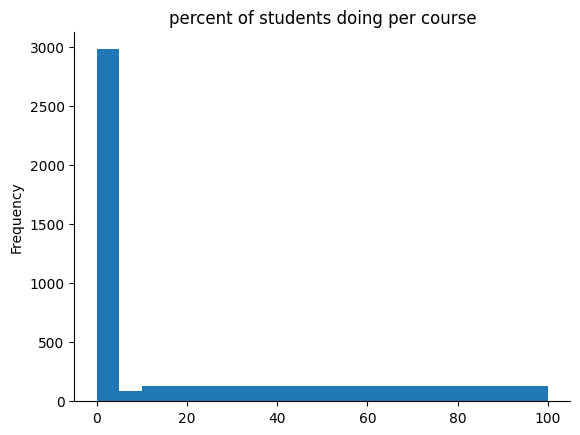

In [ ]:
from matplotlib import pyplot as plt
exercise_engagement_per_course['percent_students_doing'].plot(
    kind='hist',
    bins=[0, 5., 10., 100],
    title='percent of students doing per course'
)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [2]:
!gdown 1ixsMRCsTFEZOYtpg302HLwZQcUezCCmU

Downloading...
From: https://drive.google.com/uc?id=1ixsMRCsTFEZOYtpg302HLwZQcUezCCmU
To: /content/exercise_engagement_per_course.csv
100% 61.7k/61.7k [00:00<00:00, 4.81MB/s]


In [4]:
import pandas as pd

In [18]:
courses = pd.read_json('https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/course.json', lines=True)
courses = courses.rename({'id': 'course_id'}, axis='columns')
courses

,course_id,name,field,prerequisites,about,resource
0,C_584313,《资治通鉴》导读,"[历史学, 中国语言文学]",,通过老师导读，同学们可深入这一经典文本内部，得以纵览千年历史，提升国学素养，体味人生智慧。,"[{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso..."
1,C_584329,微积分——极限理论与一元函数,"[应用经济学, 数学, 物理学, 理论经济学]",,本课程是理工科的一门数学基础课，系统、全面地介绍了一元函数微积分学。课程既保持了数学的严谨和...,"[{'titles': ['序言', '序言', '序言'], 'resource_id':..."
2,C_584381,新闻摄影,"[艺术学, 新闻传播学]",,掌握基本的摄影技能，了解图片新闻的工作方式，训练对生活的观察和热爱，发展对图像的审美和批评能...,"[{'titles': ['第一章 绪论', '第一讲 引言1', '引言1'], 'res..."
3,C_597208,数据挖掘：理论与算法,[计算机科学与技术],,最有趣的理论+最有用的算法=不得不学的数据科学。,"[{'titles': ['走进数据科学：博大精深，美不胜收', '整装待发', 'Vide..."
4,C_597225,大学计算机,[],,大学计算机课程将以计算思维为导向，以计算机原理、概念为基础，以新技术新方法为牵引，以创新思维...,"[{'titles': ['第1周： 基于计算机的问题求解', '课程介绍', '开篇'],..."
...,...,...,...,...,...,...
3776,C_2338076,（疾风计划）软件工程,[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第1章 初识软件工程 ', '1.1 软件无处不在 ', '讲课..."
3777,C_2341259,（疾风计划）面向对象程序设计（C++）,[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第一讲 课程简介与编程环境', '1.0 课程定位、教学内容',..."
3778,C_2337996,（疾风计划）数据结构(下),[],,疾风计划2021【首期限额招募】进行中\n名校名师丨专属助教丨专业认证丨系统全面丨修炼内功丨...,"[{'titles': ['第零章 ', '选课之前', '宣传片'], 'resourc..."
3779,C_1945689,机器学习训练营,[],,清华张敏老师带你12周掌握机器学习！8大经典算法 +7大实训 + 直播点评 + 博士助教+云...,"[{'titles': ['序-开营仪式及学习课件', None, '1.1_初识机器学习'..."


In [16]:
exercise_engagement_per_course = pd.read_csv('exercise_engagement_per_course.csv')
exercise_engagement_per_course

,course_id,percent_students_doing
0,C_1017355,9.740307
1,C_1017419,11.860175
2,C_1025064,1.875673
3,C_1025076,14.959569
4,C_1025079,0.517688
...,...,...
3199,C_955163,0.000000
3200,C_956128,0.000000
3201,C_956129,0.000000
3202,C_956130,0.025830


In [19]:
exercise_engagement_per_course = exercise_engagement_per_course.merge(courses['course_id'], how='right', on='course_id')

In [22]:
# course khong co thông tin tương tác tức là bằng 0
exercise_engagement_per_course = exercise_engagement_per_course.fillna(0)

In [25]:
exercise_engagement_per_course.sort_values('percent_students_doing', ascending=False)

,course_id,percent_students_doing
3179,C_2290902,82.456140
3595,C_2308092,81.719457
3527,C_2287011,74.448613
3208,C_1944721,74.233333
3180,C_2224832,65.753425
...,...,...
1360,C_735253,0.000000
1361,C_735255,0.000000
1363,C_735261,0.000000
1364,C_735263,0.000000


In [26]:
exercise_engagement_per_course.to_csv('final_exercise_engagement_per_course.csv')

In [27]:
exercise_engagement_per_course.describe()

,percent_students_doing
count,3781.000000
mean,1.396084
std,5.946528
min,0.000000
25%,0.000000
50%,0.000000
75%,0.221220
max,82.456140


In [28]:
exercise_engagement_rank_per_course = exercise_engagement_per_course.copy()

In [32]:
exercise_engagement_per_course[(exercise_engagement_per_course['percent_students_doing'] > 0)].describe()

,percent_students_doing
count,1272.000000
mean,4.149837
std,9.681367
min,0.000087
25%,0.211869
50%,0.795340
75%,2.953886
max,82.456140


In [56]:
# init rank
exercise_engagement_rank_per_course['rank'] = [1] * exercise_engagement_rank_per_course.shape[0]
# calculate rank by quantiles
quantiles = [(1, 0), (2, 0.2), (3, 0.6), (4, 0.85), (5, 1.)]
for index, (rank, quantile) in enumerate(quantiles[1:]):
    threshold = exercise_engagement_per_course[
        (exercise_engagement_per_course['percent_students_doing'] > 0)]\
         ['percent_students_doing'].quantile(quantile)
    print(index+1, threshold)
    pre_threshold = exercise_engagement_per_course[
        (exercise_engagement_per_course['percent_students_doing'] > 0)]\
         ['percent_students_doing'].quantile(quantiles[index][1])
    print(index, pre_threshold)
    exercise_engagement_rank_per_course.loc[
        (exercise_engagement_rank_per_course['percent_students_doing'] > pre_threshold)
        & (exercise_engagement_rank_per_course['percent_students_doing'] <= threshold),
        'rank'] = rank

1 0.13905053471010567
0 8.689663862077654e-05
2 1.2555282555282556
1 0.13905053471010567
3 6.147651500885995
2 1.2555282555282556
4 82.45614035087719
3 6.147651500885995


In [57]:
exercise_engagement_rank_per_course

,course_id,percent_students_doing,rank
0,C_584313,0.00000,1
1,C_584329,0.00000,1
2,C_584381,0.00000,1
3,C_597208,0.00000,1
4,C_597225,0.00000,1
...,...,...,...
3776,C_2338076,0.00000,1
3777,C_2341259,0.00000,1
3778,C_2337996,0.00000,1
3779,C_1945689,22.84699,5


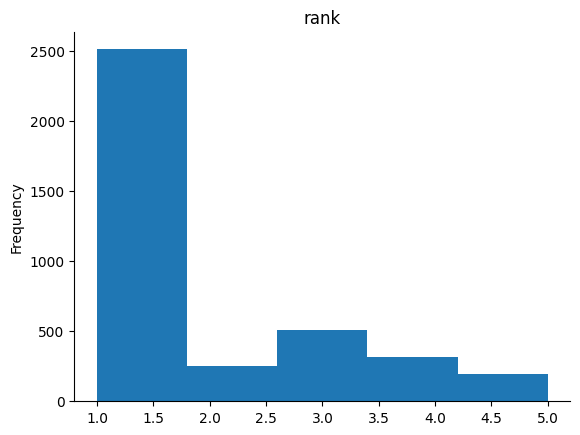

In [60]:
# @title rank

from matplotlib import pyplot as plt
exercise_engagement_rank_per_course['rank'].plot(kind='hist', bins=5, title='rank')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [58]:
exercise_engagement_rank_per_course['rank'].value_counts()

rank
1    2510
3     508
4     318
2     254
5     191
Name: count, dtype: int64

In [61]:
exercise_engagement_rank_per_course.to_csv('exercise_engagement_score_and_rank.csv')

In [ ]:
!gdown